In [1]:
using Gadfly

First I define the exponential distribution in terms of xmax. The normalizing constant for the exponential is $(-e^{-x_{max}} + 1)^{-1}$

In [2]:
# Proabably (there is) a better way to do this.
function probexp(x, xmax)
    a = (-exp(-xmax) + 1)^(-1)
    a * exp(-x)
end
probexp100(x) = probexp(x, 100)
probexp10(x) = probexp(x, 10)
# Ensure we integrate to 1
quadgk(probexp10, 0, 10)

(0.9999999999999999,1.8040754046905194e-10)

In [3]:
# Define the cost function.
# This is basically a moving window.
function totalcost(pe, fac)
    cost = 0
    left = 1
    right = 0
    for i in 1:length(fac)
        if i == length(fac)
            right = length(pe)
        else
            right = round(Int, (fac[i] + fac[i + 1]) / 2)
        end
        for j in left:right
            cost = cost + abs(fac[i] - j) * pe[j] 
        end
        left = right + 1
    end
    cost
end
a = [10,9,8,7,6,5]
# Fac at 9 and 7
b = [2,4]
@assert totalcost(a,b) == 34

In [4]:
# Define the function that randomly 
# moves facilities around
function jitterfac(pe, fac)
    newfac = copy(fac)
    for i in 1:length(fac)
        move = rand(-1:1)
        result = fac[i] + move
        if !(result < 1) && !(result > length(pe))
            if i > 1 && result != fac[i - 1]
                newfac[i] = result
            elseif i < length(fac) && result != fac[1 + 1]
                newfac[i] = result
            end
        end
    end
    newfac
end

jitterfac (generic function with 1 method)

In [5]:
# Better to set the temp too high than too low
function anneal(pe, fac, temp, tstep, itr)
    costs = zeros(itr)
    cfac = copy(fac)
    ccost = totalcost(pe, cfac)
    i = 1
    tbad = 0
    while i <= itr
        costs[i] = ccost
        nfac = jitterfac(pe, cfac)
        ncost = totalcost(pe, nfac)
        diff = ccost - ncost
        #print(diff,"|")
        if diff > 0 
            cfac = nfac
            ccost = ncost
        else
            if temp > 0 && exp(diff / temp) > rand()
                tbad = tbad + 1
                cfac = nfac
                ccost = ncost
            end
        end
        temp = temp - tstep
        i = i + 1
    end
    (costs, cfac, tbad)
end

anneal (generic function with 1 method)

Here I define the $x_{max}$, the number of cells, the step size, etc. I've preserved the ratio of cells to facilties as running the simulation with $10^7$ cells and $10^4$ facilities requires additional parallelization to be done properly.

In [57]:
# Max value of the distribution.
xmax = 10
# Percent of cells that should have a facility.
ratio = 10^4/10^7
cells = 10^4
#numfac = round(Int, ratio * cells)
numfac = 20
stepsize = (cells / xmax)
# x values to pull probabilities out of the distribution.
distarray = linspace(0, xmax, cells);
pers = 1000;
pe = round(Int, [round(pers * probexp(x, xmax)) for x in distarray]);
# locations of facilities in cell array.
fac = round(Int, linspace(stepsize / 100, cells, round(Int, numfac)));

Below we have the density of the population (the curve) and the facility locations before optimization.

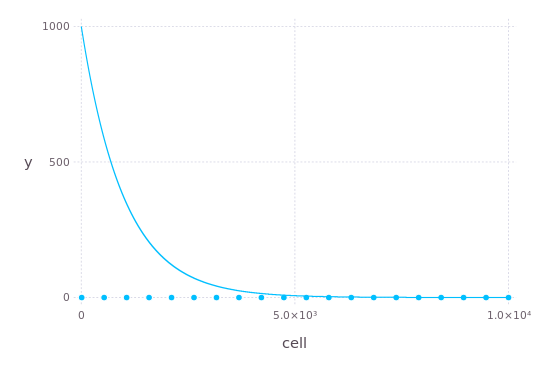

In [58]:
plot(layer(x = [x for x = 1:cells], y = pe, Geom.line),
layer(x = fac, y = [x for x = zeros(numfac)], Geom.point), Guide.xlabel("cell"))

Now we optimize.

In [63]:
temp = 10^6
tstep = 10^2
itr = 10^6
(cost, cfac, tbad) = anneal(pe, fac, temp, tstep, itr)

([1.29519e8,1.29708e8,1.29452e8,1.29199e8,1.29166e8,1.29009e8,1.28832e8,1.29023e8,1.28813e8,1.28603e8  …  5.29674e7,5.29674e7,5.29674e7,5.29674e7,5.29674e7,5.29674e7,5.29674e7,5.29674e7,5.29674e7,5.29674e7],[55,171,293,423,563,713,875,1051,1245,1459,1697,1966,2280,2650,3102,3684,4493,5833,9594,9891],4569)

See how we did...

In [ ]:
plot(x = [x for x = 1:itr], y = cost, Geom.line, Guide.xlabel("Iteration"), 
Guide.ylabel("Cost"))

We appear to have hit a local optimum. The plot below reveals we nearly got there!

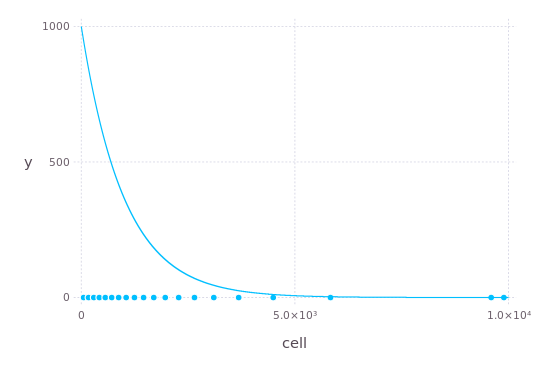

In [65]:
plot(layer(x = [x for x = 1:cells], y = pe, Geom.line),
layer(x = cfac, y = [x for x = zeros(numfac)], Geom.point), Guide.xlabel("cell"))

In [62]:
function pedensity(line, step)
    den = Array(Int, round(Int, length(line) / step))
    for j in 1:length(den)
        tot = 0
        off = (j - 1) * step
        for i in 1:step
            tot = tot + line[off + i]
        end
        den[j] = tot 
    end
    den
end
@assert pedensity([1,2,3,4,5,6,7,8,9,10], 2) == [3,7,11,15,19]

Try and get an idea of density. This doesn't really work. I'm including it only because I spent some time realizing this doesn't work.

In [66]:
block = 10^3
popden = pedensity(pe, block);
fad = zeros(Int, length(pe))
fad[cfac] = 1
facden = pedensity(fad, block);

In [18]:
using GLM, DataFrames

In [69]:
good = 4
data = DataFrame(x = log(10, popden[1:good]), y = log(10, facden[1:good]))

,x,y
1,5.801022763468258,0.8450980400142567
2,5.3666843891789435,0.6989700043360187
3,4.93233675765959,0.30102999566398114
4,4.497993334057702,0.30102999566398114


In [70]:
fit(LinearModel, y ~ x, data)

DataFrameRegressionModel{LinearModel{DensePredQR{Float64}},Float64}:

Coefficients:
             Estimate Std.Error  t value Pr(>|t|)
(Intercept)  -1.87038  0.612411 -3.05412   0.0926
x            0.467405  0.118401  3.94765   0.0586


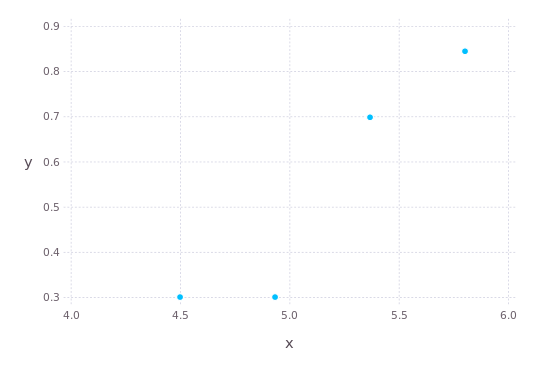

In [71]:
plot(data,x = "x", y = "y")